## Introduction

This is a final project from the Udacity's Data Analysis course, more specifically from the "Wrangle and Analyze Data" section. The goal of this project is to wrangle and, after that, analyze and visualize the data from the Twitter Account "WeRateDogs". 

The project can be divided into 2 Parts: Wrangle and Analyze.
By Wrangle, one can understand by:
    1. Data Gathering
    2. Data Assessing
    3. Data Cleaning
    
The second part consist on the store, analyze and visualization of our cleaned data. 

One can find more details on the following reports:
    - Wrangle Report (Part I)
    - Act Report (Part II)

## Import Libraries

In [119]:
import pandas as pd 
import numpy as np
import requests  #To download files from the Internet through URL
import tweepy
import os  # Import OS to write, read, files from the Internet with images
import json
import time
import re
import warnings


#Import matplotlib and seaborn to display graphics and good visualizations of the data
import matplotlib.pyplot as plt  
%matplotlib inline

import seaborn as sns

## Data Gathering

The first step of this project is to gather our data, which is splitted in 3 different datasets / formats / places, and then merge them together. Below the 3 datasets we need to import:
 1. An excel file, in a csv format, that was manually downloaded from the Project Instructions: twitter_archive_enhanced.csv
 2. Image_predictions.tsv file,  which should be downloaded programmatically from an URL
 3. Data extraction using Twitter API. We will query the Twitter API for each tweet's JSON data using Python's Tweepy library. The reason to use the Twitter API is to gather extra and missing data from the excel file, such as the favorites and retweets. Thus, we need the additional data for each tweet_id

Import the Excel, CSV (PART I of the data)

In [120]:
df_excel=pd.read_csv('twitter-archive-enhanced.csv')  
df_excel.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [121]:
df_excel.shape

(2356, 17)

In [122]:
df_excel.name.value_counts()

None           745
a               55
Charlie         12
Cooper          11
Lucy            11
Oliver          11
Penny           10
Tucker          10
Lola            10
Winston          9
Bo               9
Sadie            8
the              8
Toby             7
Bailey           7
Buddy            7
an               7
Daisy            7
Koda             6
Scout            6
Rusty            6
Stanley          6
Oscar            6
Dave             6
Milo             6
Leo              6
Jack             6
Jax              6
Bella            6
Alfie            5
              ... 
Howie            1
Roscoe           1
Alejandro        1
Bauer            1
Venti            1
Tito             1
Rascal           1
Shakespeare      1
Molly            1
Grey             1
Sprout           1
Emanuel          1
Stormy           1
Hubertson        1
Diogi            1
Jeffrie          1
Stark            1
Rodman           1
Lili             1
Kanu             1
Millie           1
Alf         

Import Data from the URL (PART II)

In [123]:
import requests

url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)
with open ("599fd2ad_image-prediction.tsv", mode='wb') as file:
    file.write(response.content)

In [124]:
df_img = pd.read_csv('599fd2ad_image-prediction.tsv', sep = '\t')
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [125]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


IMPORT DATA THROUGHT TWITTER API (PART III)
    
     -It is important to highlight that I faced inumerous problems when trying to import the data through the API. I reached out to Udacity's mentors and we tried a lot of different solutions, unfortunattely without success. The problem might be due to the antivirus of my computer. Thus, I imported Twitter's information directly from the txt file provided by 
     Udacity, as advised by the mentor. 
     - The errors are stored below

In [126]:
df_tweet = pd.read_json('tweet-json.txt', lines=True)
df_tweet

#df_tweet.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [127]:
# STORING THE ERROR WHEN TRYING TO ACCESS THE TWITTER API

In [128]:
#import tweepy
#from tweepy import OAuthHandler
#import json
#from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions

#consumer_key = 'HIDDEN'
#consumer_secret = 'HIDDEN'
#access_token = 'HIDDEN'
#access_secret = 'HIDDEN'

#auth = OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True)

#tweet_ids = df_excel.tweet_id.values
#len(tweet_ids)

In [129]:
#df_list = []
#error_list = []

#start = time.time()

# Will add each available tweet json to df_list
#for tweet_id in df_excel['tweet_id']:
 #   try:
  #      tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit = True,
     #                          wait_on_rate_limit_notify = True)._json 
   #     favorites = tweet['favorite_count'] # tweet's favorites
    #    retweets = tweet['retweet_count'] 
      #  user_followers = tweet['user']['followers_count'] 
       # user_favourites = tweet['user']['favourites_count'] # user's favorites
        #date_time = tweet['created_at'] # The date and time of the creation
        
       # df_list.append({'tweet_id': int(tweet_id), 'favorites': int(favorites), 'retweets': int(retweets),
        #                'user_followers': int(user_followers), 'user_favourites': int(user_favourites),
         #               'date_time': pd.to_datetime(date_time)})
        
    #except Exception as e:
     #   print(str(tweet_id)+ " __ " + str(e))
      #  error_list.append(tweet_id)
        

#end = time.time()
#print(end - start)

In [130]:
#print("The lengh of the result", len(df_list))
#print("The lengh of the errors", len(error_list))

Therefore, we gathered all three datasets:

    tweet_json.txt as df_tweet
    image_predictions.tsv as df_img
    twitter_archive_enhanced.csv as df_excel

## Data Assessing

The issues of the above databases will be listed in this Data Assesing Chapter and therefore cleaned on the Cleaning Section just straight after. 
Data Asses issues can be divided in two types:

    . Quality issues: 
    Wrong data format, missing data, duplicates, incorrect data
    
    . Tidness issues:
    By a Tidy Data we mean that each variable is a column, each observation is a row, and each type of observational unit
    is a table.

As in the Project Guidelines, one need to identify 8 data quality issues and 2 tidiness issues.

### df_excel // 'twitter-archive-enhanced.csv'

In [131]:
df_excel.head(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [132]:
df_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Quality issues in a first glance:
    1. rating_numerator & rating_denominator should be converted from int to float
    2. timestamp should be converted into datetime
    3. tweet_id, such as all the columns with ids should be a string
   

In [133]:
df_excel.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

TIDNESS ISSUES:

1. Doggo, Floofer, Pupper and Puppo are dogs' categories and therefore should be in the same column and not in 4 different columns splitted. Thus, one need to melt these categories and a new created column
2. All the datasets needed to be merged into one, not considering the repeated columns 

In [134]:
df_excel.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


Numerator fluctuating from 0 to 1776, denominator fluctuating from 0 to 170, and it should be fixed.

In [135]:
df_excel.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [136]:
df_excel.name.value_counts()

None           745
a               55
Charlie         12
Cooper          11
Lucy            11
Oliver          11
Penny           10
Tucker          10
Lola            10
Winston          9
Bo               9
Sadie            8
the              8
Toby             7
Bailey           7
Buddy            7
an               7
Daisy            7
Koda             6
Scout            6
Rusty            6
Stanley          6
Oscar            6
Dave             6
Milo             6
Leo              6
Jack             6
Jax              6
Bella            6
Alfie            5
              ... 
Howie            1
Roscoe           1
Alejandro        1
Bauer            1
Venti            1
Tito             1
Rascal           1
Shakespeare      1
Molly            1
Grey             1
Sprout           1
Emanuel          1
Stormy           1
Hubertson        1
Diogi            1
Jeffrie          1
Stark            1
Rodman           1
Lili             1
Kanu             1
Millie           1
Alf         

In [137]:
names_todelete=df_excel[df_excel['name'].apply(len) < 3]

In [138]:
names_todelete.name.value_counts()
#Short names could represent misspelled names, we might want to delete them.

a     55
Bo     9
an     7
Mo     1
Jo     1
O      1
Ed     1
my     1
by     1
JD     1
Al     1
Name: name, dtype: int64

In [139]:
df_excel.rating_denominator.value_counts() 
#The denominator should be fix and equal to 10 once we want the rates of the dogs to 
# be greater than 10 in the We Rate Dogs account

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [140]:
df_excel.rating_numerator.value_counts() #should not be greater than 20

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [141]:
incorrect_numerator=df_excel[df_excel['rating_numerator'] > 20]
incorrect_numerator

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [142]:
incorrect_numerator.shape

(24, 17)

In [143]:
df_excel.tweet_id.duplicated().sum() #check if there are duplicates in our database

0

In [144]:
df_filtered=df_excel[df_excel['in_reply_to_user_id'].isnull()] 
                     
df_filtered2=df_filtered[df_filtered['retweeted_status_user_id'].isnull()]
df_filtered2.head(15)

#The columns retweeted_status_user_id and in_reply_to_user_id are counting the replies and retweets. 
#Once we just want the original tweets, we should consider a dataframe where those values are null.

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


ASSESSING SUMMARY: DF_EXCEL

QUALITY ISSUES


1. rating_numerator & rating_denominator should be converted from int to float
2. timestamp should be converted into datetime 
3. tweet_id should be a string (we might not need to use the other columns where we have 'ids', so no need to change) 
4. The numerator and denominator columns have invalid values - they fluctuate a lot as shown in the describe() function 
5. There are invalid dogs' names - We started by looking at those names with len<3 and then realized that it would be better to exclude those that start with a lower case latter, as they seem the wrong ones (there are short names such as Ed, Bo, that actually seem dog's names)
6. We only want original ratings tweets, not retweets or replies 

TIDNESS ISSUES:

    - Doggo, Floofer, Pupper and Puppo are dogs' categories and therefore should be in the same column and not in different columns splitted. Thus, one need to melt these categories and a new created column 
    - All the datasets needed to be merged into one, not considering the repeated columns

### image_predictions.tsv

In [145]:
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [146]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [147]:
df_img.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [148]:
df_img['tweet_id'].duplicated().sum()

0

In [149]:
df_img['jpg_url'].duplicated().sum() ## to remove the duplicated tweets / meaning replies or retweets.

66

In [150]:
df_dupli=df_img[df_img['jpg_url'].duplicated()]
#df_dupli['tweet_id'].nunique()
df_dupli

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


QUALITY ISSUES:

   1. Twitter_ID should be string 
   2. p1, p3, p3 should be strandardized with Capital Letters or /and lower cases. 
   3. Rows where p1 & p2 & p3 values are "FALSE" should be removed because we want just dog's with breed predictions 
   4. We should remove the rows duplicated jpg urls, so we can me sure we are considering the original image tweets 

TIDNESS ISSUES:
    1. Missing values from images dataset (2075 rows instead of 2356)

DF_TWEET

In [151]:
df_tweet.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

DF_TWEET

In [152]:
dfdupli_tweet= df_tweet[df_tweet['id'].duplicated()]

dfdupli_tweet

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user


### SUMMARY:

QUALITY ISSUES

    1) DF_EXCEL - 'twitter_archive_enhanced.csv: 
1. rating_numerator & rating_denominator should be converted from int to float
2. timestamp should be converted into datetime  
3. tweet_id should be a string (we might not need to use the other columns where we have 'ids', so no need to change)  
4. The numerator and denominator columns have invalid values. We should keep the denominator equal 10 and do not consider numerators higher than 20
5. There are invalid dogs' names - We started by looking at those names with len<3 and then realized that it would be better to exclude those that start with a lower case latter, as they seem the wrong ones
6. We only want original ratings tweets, not retweets or replies  
    
    2) DF_IMG - image_predictions.tsv':
7. Twitter_ID should be string  
8. p1, p3, p3 should be strandardized with Capital Letters or /and Lower cases.
9. Rows where p1 & p2 & p3 values are "FALSE" should be removed because we want just dog's with breed predictions
10. We should remove the rows duplicated jpg urls, so we can me sure we are considering the original image tweets

    3) Final - the merge all 3 databases (including tweet_json.txt):
11. Delete tweet_ids with more than 1 dog breed
12. Remove the useful columns such as in_reply_to_status_id, in_reply_to_user_id, retweeted_status_timestamp, retweeted_status_id, retweeted_status_user_id 

TIDNESS ISSUES:

     1) DF_EXCEL
    1. Doggo, Floofer, Pupper and Puppo are dogs'stages and therefore should be in the same column and not splitted in different columns. Thus, one need to melt these stages in a new column 

     2) DF_IMG
    2. Missing values from images dataset (2075 rows instead of 2356)
     
     3)DF_FINAL
    3. All the datasets needed to be merged into one ("final" df), not considering the repeated columns - Gather data from 
    the tweet_json.txt file - retweets and favoites' data.

## Data Cleaning

In [153]:
#copy dataframes
df_img_clean = df_img.copy()
df_excel_clean = df_excel.copy()
df_tweet_clean= df_tweet.copy()

## QUALITY

## 1. DF_IMG

### Issue 1 - Quality 
#### Remove duplicated jgp_url from df_img

In [154]:
df_img.shape

(2075, 12)

In [155]:
df_img_clean=df_img.drop_duplicates(subset="jpg_url")
df_img_clean.shape

(2009, 12)

We removed the 66 duplicated observations

In [156]:
df_img_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2009 non-null int64
jpg_url     2009 non-null object
img_num     2009 non-null int64
p1          2009 non-null object
p1_conf     2009 non-null float64
p1_dog      2009 non-null bool
p2          2009 non-null object
p2_conf     2009 non-null float64
p2_dog      2009 non-null bool
p3          2009 non-null object
p3_conf     2009 non-null float64
p3_dog      2009 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 162.8+ KB


## Issue 2 - Quality
#### Change tweet_id type to string, therefore we can merge the dfs later

In [157]:
df_img_clean['tweet_id']=df_img_clean['tweet_id'].astype(str)
df_img_clean['tweet_id'].dtype

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


dtype('O')

## Issue 3 - Quality 
#### We should remove the rows where p1, p2 and  p3 values are False, because it means that we never have a dog breed prediction

In [158]:
df_img_clean2=df_img_clean[['p1_dog', 'p2_dog', 'p3']]
df_img_clean2

,p1_dog,p2_dog,p3
0,True,True,Shetland_sheepdog
1,True,True,Rhodesian_ridgeback
2,True,True,bloodhound
3,True,True,miniature_pinscher
4,True,True,Doberman
5,True,True,Greater_Swiss_Mountain_dog
6,False,False,terrapin
7,True,True,fur_coat
8,False,False,golden_retriever
9,True,True,soft-coated_wheaten_terrier


In [159]:
new_img=df_img_clean[(df_img_clean.p1_dog == False) & (df_img_clean.p2_dog == False) & (df_img_clean.p3_dog == False)]
new_img.info()
#new_img['p3_dog'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 6 to 2074
Data columns (total 12 columns):
tweet_id    318 non-null object
jpg_url     318 non-null object
img_num     318 non-null int64
p1          318 non-null object
p1_conf     318 non-null float64
p1_dog      318 non-null bool
p2          318 non-null object
p2_conf     318 non-null float64
p2_dog      318 non-null bool
p3          318 non-null object
p3_conf     318 non-null float64
p3_dog      318 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 25.8+ KB


In [160]:
df_img_clean=df_img_clean[(df_img_clean.p1_dog == True) | (df_img_clean.p2_dog == True) | (df_img_clean.p3_dog == True)]
df_img_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1691 non-null object
jpg_url     1691 non-null object
img_num     1691 non-null int64
p1          1691 non-null object
p1_conf     1691 non-null float64
p1_dog      1691 non-null bool
p2          1691 non-null object
p2_conf     1691 non-null float64
p2_dog      1691 non-null bool
p3          1691 non-null object
p3_conf     1691 non-null float64
p3_dog      1691 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 137.1+ KB


## Issue 4 - Quality 
#### p1, p2, p3 columns should be strandardized with Capital Letters or /and lower cases

In [161]:
df_img_clean['p3'] = df_img_clean['p3'].str.title()  
df_img_clean['p2'] = df_img_clean['p2'].str.title()
df_img_clean['p1'] = df_img_clean['p1'].str.title()

df_img_clean
#str.title() function to change the first and second name of the breed.

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_Springer_Spaniel,0.465074,True,Collie,0.156665,True,Shetland_Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_Mountain_Dog,0.651137,True,English_Springer,0.263788,True,Greater_Swiss_Mountain_Dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,Chow,0.692517,True,Tibetan_Mastiff,0.058279,True,Fur_Coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,Shopping_Cart,0.962465,False,Shopping_Basket,0.014594,False,Golden_Retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,Miniature_Poodle,0.201493,True,Komondor,0.192305,True,Soft-Coated_Wheaten_Terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,Golden_Retriever,0.775930,True,Tibetan_Mastiff,0.093718,True,Labrador_Retriever,0.072427,True


#### Also replacing the white spaces with"_" to standardize the dataframe 

In [162]:
df_img_clean['p1']=df_img_clean['p1'].str.replace(' ', '_', regex=True)
df_img_clean['p2']=df_img_clean['p2'].str.replace(' ', '_', regex=True)
df_img_clean['p3']=df_img_clean['p3'].str.replace(' ', '_', regex=True)
df_img_clean.head(12)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_Springer_Spaniel,0.465074,True,Collie,0.156665,True,Shetland_Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_Mountain_Dog,0.651137,True,English_Springer,0.263788,True,Greater_Swiss_Mountain_Dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,Chow,0.692517,True,Tibetan_Mastiff,0.058279,True,Fur_Coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,Shopping_Cart,0.962465,False,Shopping_Basket,0.014594,False,Golden_Retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,Miniature_Poodle,0.201493,True,Komondor,0.192305,True,Soft-Coated_Wheaten_Terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,Golden_Retriever,0.775930,True,Tibetan_Mastiff,0.093718,True,Labrador_Retriever,0.072427,True


In [163]:
df_img_clean.tail(6) #Checking with all the changes were applied

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_Collie,0.199287,True,Ice_Lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_Retriever,0.425595,True,Irish_Terrier,0.116317,True,Indian_Elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True


## 2. Df_excel

## Issue 5 - Quality
#### Keep only original tweets - Remove retweets and replies in order to keep only the original tweets, one way to do this is to filter by the columns where reply and retweets ids are nulls

In [164]:
df_excel_clean.shape

(2356, 17)

In [165]:
df_excel_clean=df_excel_clean[df_excel_clean['in_reply_to_user_id'].isnull()] 
                     
df_excel_clean=df_excel_clean[df_excel_clean['retweeted_status_user_id'].isnull()]
df_excel_clean.shape

(2097, 17)

## Issue 6 - Quality 
#### Twitter ID must be a string

In [166]:
df_excel_clean['tweet_id']=df_excel_clean['tweet_id'].astype(str)
df_excel_clean['tweet_id'].dtype # double check if it worked

dtype('O')

## Issue 7 - Quality
#### Timestamp should be converted into datetime

In [167]:
df_excel_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(2), object(11

In [168]:
df_excel_clean['timestamp'].dtype

dtype('O')

In [169]:
df_excel_clean['timestamp']=pd.to_datetime(df_excel_clean['timestamp'])

#df_excel_clean['timestamp']=df_excel_clean['timestamp'].astype(datetime)

#df_excel_clean.timestamp = df_excel_clean.timestamp.apply(np.datetime64)
df_excel_clean['timestamp'].dtype

dtype('<M8[ns]')

In [170]:
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]') #Check if datetime is the same as M8 in this python version

True

## Issue 8 - Quality
#### Rating_numerator & Rating_denominator should be converted from int to float

In [171]:
df_excel_clean['rating_numerator']=df_excel_clean['rating_numerator'].astype('float')
df_excel_clean['rating_denominator']=df_excel_clean['rating_denominator'].astype('float')
print(df_excel_clean['rating_numerator'].dtype, df_excel_clean['rating_denominator'].dtype)

float64 float64


##  TIDNESS

### Issue 1 - Tidness
#### MERGE OF THE DATAFRAMES DF_IMG AND DF_EXCEL
      - The missing issues will be solved after the merge

In [172]:
twt_mstr = pd.merge(df_excel_clean, df_img_clean, how= 'left', on = ['tweet_id'])
twt_mstr

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,1.0,Chesapeake_Bay_Retriever,0.425595,True,Irish_Terrier,0.116317,True,Indian_Elephant,0.076902,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,1.0,Appenzeller,0.341703,True,Border_Collie,0.199287,True,Ice_Lolly,0.193548,False
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,2.0,Pomeranian,0.566142,True,Eskimo_Dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,1.0,Irish_Terrier,0.487574,True,Irish_Setter,0.193054,True,Chesapeake_Bay_Retriever,0.118184,True
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,1.0,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


In [173]:
twt_mstr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 28 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null float64
rating_denominator            2097 non-null float64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
jpg_url                    

## Issue 9 - Quality 
### Remove incorrect dog names

In [174]:
delete=twt_mstr[twt_mstr['name'].apply(len) < 3]
delete.name.value_counts()

a     55
an     6
Bo     6
Mo     1
Jo     1
O      1
Ed     1
my     1
by     1
JD     1
Al     1
Name: name, dtype: int64

#### Instead of deleting those, lets before check the ones with lower case, once names like Bo, Ed and Jo could be Dog's Names. 

In [175]:
non_names = []

# Loop to find ordinary word.
for index in twt_mstr.name:
    # Will check every name start with lowercase.
    if index.islower():
        # If yes will append to non_names
        non_names.append(index)

# The list will filter only unique values
non_names = list(set(non_names))
non_names

['a',
 'the',
 'one',
 'my',
 'by',
 'very',
 'not',
 'old',
 'infuriating',
 'his',
 'light',
 'space',
 'unacceptable',
 'this',
 'an',
 'quite',
 'actually',
 'getting',
 'all',
 'mad',
 'incredibly',
 'such',
 'just',
 'life',
 'officially']

In [176]:
for index in non_names:
    twt_mstr.name.replace(index,"error",inplace = True)

In [177]:
twt_mstr.shape

(2097, 28)

In [178]:
twt_mstr=twt_mstr[twt_mstr.name != "error"]
twt_mstr.shape

(1993, 28)

## Issue 10 - Quality
### The numerator and denominator columns have invalid values 
    - Excluding from the database the wrong numerators and denominators

In [179]:
twt_mstr['rating_numerator'].value_counts()

12.0      471
10.0      413
11.0      397
13.0      280
9.0       139
8.0        91
7.0        46
14.0       34
5.0        33
6.0        30
3.0        18
4.0        13
2.0         7
1.0         4
45.0        1
84.0        1
99.0        1
1776.0      1
75.0        1
165.0       1
88.0        1
0.0         1
24.0        1
80.0        1
27.0        1
144.0       1
26.0        1
44.0        1
121.0       1
50.0        1
420.0       1
Name: rating_numerator, dtype: int64

In [180]:
num_toexclude=twt_mstr[twt_mstr['rating_numerator'] > 20]
num_toexclude

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
339,820690176645140481,NaN,NaN,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,...,2.0,West_Highland_White_Terrier,0.872064,True,Kuvasz,0.059526,True,Samoyed,0.037400,True
403,810984652412424192,NaN,NaN,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",...,1.0,Golden_Retriever,0.871342,True,Tibetan_Mastiff,0.036708,True,Labrador_Retriever,0.025823,True
528,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,...,1.0,Pomeranian,0.467321,True,Persian_Cat,0.122978,False,Chow,0.102654,True
586,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,...,1.0,Clumber,0.946718,True,Cocker_Spaniel,0.015950,True,Lhasa,0.006519,True
700,758467244762497024,NaN,NaN,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,...,1.0,Labrador_Retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_Terrier,0.099689,True
770,749981277374128128,NaN,NaN,2016-07-04 15:00:45,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
985,716439118184652801,NaN,NaN,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,...,1.0,Siberian_Husky,0.396495,True,Malamute,0.317053,True,Eskimo_Dog,0.273419,True
1011,713900603437621249,NaN,NaN,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,...,1.0,Golden_Retriever,0.371816,True,Cocker_Spaniel,0.177413,True,Irish_Setter,0.092725,True
1036,710658690886586372,NaN,NaN,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,...,1.0,Soft-Coated_Wheaten_Terrier,0.948617,True,Dandie_Dinmont,0.018664,True,Cairn,0.015943,True
1056,709198395643068416,NaN,NaN,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,...,1.0,Borzoi,0.490783,True,Wire-Haired_Fox_Terrier,0.083513,True,English_Setter,0.083184,True


In [181]:
for index in twt_mstr.tweet_id:
    # Extracting the text of each tweet
    twt_txt = twt_mstr[twt_mstr.tweet_id == index].text.tolist()[0]
    # This regex will find any "float" rating among the words text.
    rating = re.findall('\d+\.\d+\/\d+', twt_txt)
    # If any rating were found, the length of rating will be different of zero
    if len(rating) > 0:
        # rating is a list of one element like this [9.9/10], I want only the first part the 9.9.
        numerator = rating[0].split('/')[0]
        # This is the hard part. I must use the .loc() to update the data alocated in twt_ach_mstr Data Frame.
        twt_mstr.loc[twt_mstr[twt_mstr['tweet_id'] == index].index,'rating_numerator'] = float(numerator)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [182]:
# Loop to find any non integer rating.
for index in twt_mstr.tweet_id:
    # Extracting the text of each tweet
    twt_txt = twt_mstr[twt_mstr.tweet_id == index].text.tolist()[0]
    # This regex will find the pattern NN/NN.
    rating = re.findall('\d+\d\/\d+', twt_txt)
    # If any rating is a list of two elements.
    if len(rating) == 2:
        if(rating[0] == '50/50'):
            # rating is a list of two elements like this [50/50, 9.9/10], I want only the first part of the second element.
            numerator = rating[1].split('/')[0]
            denominator = rating[1].split('/')[1]
            # This is the hard part. I must use the .loc() to update the data alocated in twt_ach_mstr Data Frame.
            twt_mstr.loc[twt_mstr[twt_mstr['tweet_id'] == index].index,'rating_numerator'] = float(numerator)
            twt_mstr.loc[twt_mstr[twt_mstr['tweet_id'] == index].index,'rating_denominator'] = float(denominator)
        else:
            # Average of two ratings.
            numerator = (float(rating[0].split('/')[0]) + float(rating[1].split('/')[0])) * 0.5
            # This is the hard part. I must use the .loc() to update the data alocated in twt_ach_mstr Data Frame.
            twt_mstr.loc[twt_mstr[twt_mstr['tweet_id'] == index].index,'rating_numerator']

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [183]:
for index in twt_mstr.query('rating_numerator > 20').tweet_id:
    # Extracting the text of each tweet
    twt_txt = twt_mstr[twt_mstr.tweet_id == index].text.tolist()[0]
    # This regex will find the pattern NN/NN.
    rating = re.findall('\d+\d\/\d+', twt_txt)
    # If any rating were found, the length of rating will be different of zero
    if len(rating) == 1:
        # rating is a list like this [9.9/10], I want only the first part
        numerator = float(rating[0].split('/')[0])
        denominator = float(rating[0].split('/')[1])
        # This is the hard part. I must use the .loc() to update the data alocated in twt_ach_mstr Data Frame.
        twt_mstr.loc[twt_mstr[twt_mstr['tweet_id'] == index].index,'rating_numerator'] = numerator/(denominator/10)
        twt_mstr.loc[twt_mstr[twt_mstr['tweet_id'] == index].index,'rating_denominator'] = denominator/(denominator/10)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [184]:
denominator_problem = twt_mstr.rating_denominator.value_counts().index[1:].tolist()
 
tweet_id_denominator_problem = twt_mstr[twt_mstr.rating_denominator.isin(denominator_problem)].tweet_id

for index in tweet_id_denominator_problem:
    # Extracting the text of each tweet
    twt_txt = twt_mstr[twt_mstr.tweet_id == index].text.tolist()[0]
    # This regex will find the pattern NN/NN.
    rating = re.findall('\d+\d\/\d+', twt_txt)
    # Only update if the rating is valid rating NN/NN
    if len(rating) == 1:
        numerator = rating[0].split('/')[0]
        denominator = rating[0].split('/')[1]
        twt_mstr.loc[twt_mstr[twt_mstr['tweet_id'] == index].index,'rating_numerator'] = float(numerator)
        twt_mstr.loc[twt_mstr[twt_mstr['tweet_id'] == index].index,'rating_denominator'] = float(denominator)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [185]:
twt_mstr.rating_numerator.value_counts()

12.000000      473
10.000000      415
11.000000      403
13.000000      281
9.000000       139
8.000000        91
7.000000        45
14.000000       35
5.000000        32
6.000000        30
3.000000        18
4.000000        12
2.000000         7
1.000000         4
1776.000000      1
9.750000         1
0.000000         1
34.285714        1
13.500000        1
11.260000        1
11.270000        1
420.000000       1
Name: rating_numerator, dtype: int64

In [186]:
twt_mstr.rating_numerator.shape

(1993,)

In [187]:
twt_mstr=twt_mstr[twt_mstr.rating_numerator <= 20.0] 
twt_mstr.rating_numerator.shape

(1990,)

In [188]:
twt_mstr.rating_denominator.value_counts()

10.0    1990
Name: rating_denominator, dtype: int64

In [189]:
twt_mstr.rating_numerator.value_counts()

12.00    473
10.00    415
11.00    403
13.00    281
9.00     139
8.00      91
7.00      45
14.00     35
5.00      32
6.00      30
3.00      18
4.00      12
2.00       7
1.00       4
11.26      1
9.75       1
0.00       1
13.50      1
11.27      1
Name: rating_numerator, dtype: int64

## Issue 2 - TIDNESS 
#### Doggo, Floofer, Pupper and Puppo are dogs' categories and therefore should be in the same column and not in 4 different columns splitted. Thus, one need to melt these categories and a new created column

In [190]:
twt_mstr.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [191]:
twt_mstr.pupper.value_counts()

None      1772
pupper     218
Name: pupper, dtype: int64

In [192]:
categories = ['doggo', 'floofer', 'pupper', 'puppo']
STAY_COLUMNS = [x for x in twt_mstr.columns.tolist() if x not in categories]


# Melt function
twt_mstr = pd.melt(twt_mstr, id_vars = STAY_COLUMNS, value_vars = categories, 
                         var_name = 'stages', value_name = 'dog_stage')

# We can delete column 'stages' once this info is replicated in 'dog_stage' column

#twitter_archive_clean = twitter_archive_clean.drop('stages', 
twt_mstr.drop(columns=['stages'], inplace=True)
twt_mstr

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,Chesapeake_Bay_Retriever,0.425595,True,Irish_Terrier,0.116317,True,Indian_Elephant,0.076902,False,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,Appenzeller,0.341703,True,Border_Collie,0.199287,True,Ice_Lolly,0.193548,False,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,Pomeranian,0.566142,True,Eskimo_Dog,0.178406,True,Pembroke,0.076507,True,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,Irish_Terrier,0.487574,True,Irish_Setter,0.193054,True,Chesapeake_Bay_Retriever,0.118184,True,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,doggo


In [193]:
twt_mstr.dog_stage.value_counts()

None       7628
pupper      218
doggo        80
puppo        24
floofer      10
Name: dog_stage, dtype: int64

### Issue 11 - Quality 
    - Delete tweet_ids with more than 1 dog breed

In [194]:
#Delete dog_stage duplicates
twt_mstr.groupby(['tweet_id'])['dog_stage'].value_counts()
twt_mstr=twt_mstr.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

In [195]:
twt_mstr.columns #just checking if the dogs categories are not in columns anymore

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'dog_stage'],
      dtype='object')

In [196]:
x=twt_mstr.groupby('tweet_id')['dog_stage'].value_counts()
x # check if the ids with more than one dog_stage were deleted

tweet_id            dog_stage
666020888022790149  None         1
666049248165822465  None         1
666071193221509120  None         1
666073100786774016  None         1
666082916733198337  None         1
666094000022159362  None         1
666099513787052032  None         1
666102155909144576  None         1
666104133288665088  None         1
666268910803644416  None         1
666273097616637952  None         1
666345417576210432  None         1
666353288456101888  None         1
666362758909284353  None         1
666373753744588802  None         1
666396247373291520  None         1
666418789513326592  None         1
666421158376562688  None         1
666428276349472768  None         1
666430724426358785  None         1
666435652385423360  None         1
666437273139982337  None         1
666447344410484738  None         1
666454714377183233  None         1
666644823164719104  None         1
666649482315059201  None         1
666691418707132416  None         1
666739327293083650  None 

## Issue 3 - TIDNESS

Gather data from the tweet_json.txt file - retweet and favorites count info.

As a requirement of the instruction, lets create a new column called favorite_count.

In [197]:
df_tweet_clean.head(10) #Taking a look again at the database

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [198]:
df_tweet_clean.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

In [199]:
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [200]:
df_tweet_clean['id'] = df_tweet_clean['id'].astype(str)
df_tweet_clean['id'].dtype

dtype('O')

In [201]:
df_tweet2=df_tweet_clean[['id', 'favorite_count', 'retweet_count']]
df_tweet2.rename(columns={"id": "tweet_id"},inplace=True)
df_tweet2

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774
5,891087950875897856,20562,3261
6,890971913173991426,12041,2158
7,890729181411237888,56848,16716
8,890609185150312448,28226,4429
9,890240255349198849,32467,7711


In [202]:
twt_mstr.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'dog_stage'],
      dtype='object')

In [203]:
# Merge of favourites on the master df twt_mstr
twt_mstr = pd.merge(twt_mstr, df_tweet2, how = 'left', on=['tweet_id'])

In [204]:
twt_mstr.head() #Check if the merge worked

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,favorite_count,retweet_count
0,667544320556335104,NaN,NaN,2015-11-20 03:25:43,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial. Kial is either wearing a cape, w...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/667544320...,...,True,Pembroke,0.312958,True,Chihuahua,0.071960,True,None,917,568
1,667546741521195010,NaN,NaN,2015-11-20 03:35:20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George. George took a selfie of his ne...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667546741...,...,True,Miniature_Poodle,0.202225,True,Teddy,0.004047,False,None,355,138
2,667549055577362432,NaN,NaN,2015-11-20 03:44:31,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Never seen dog like this. Breathes heavy. Tilt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667549055...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,6138,2454
3,667724302356258817,NaN,NaN,2015-11-20 15:20:54,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",What a dog to start the day with. Very calm. L...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667724302...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,517,341
4,667728196545200128,NaN,NaN,2015-11-20 15:36:22,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Olive. He comes to spot by tree to remini...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667728196...,...,True,Golden_Retriever,0.293744,True,Labrador_Retriever,0.270673,True,None,398,162


In [205]:
twt_mstr.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'dog_stage', 'favorite_count', 'retweet_count'],
      dtype='object')

### Issue 12 - Quality
    - Remove in_reply_to_status_id, in_reply_to_user_id, retweeted_status_timestamp, retweeted_status_id, retweeted_status_user_id.

In [206]:
twt_mstr.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_timestamp', 'retweeted_status_id', 'retweeted_status_user_id'], axis=1, inplace=True)

In [207]:
twt_mstr.columns #check if they were removed

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'dog_stage', 'favorite_count', 'retweet_count'],
      dtype='object')

In [208]:
twt_mstr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 22 columns):
tweet_id              1990 non-null object
timestamp             1990 non-null datetime64[ns]
source                1990 non-null object
text                  1990 non-null object
expanded_urls         1987 non-null object
rating_numerator      1990 non-null float64
rating_denominator    1990 non-null float64
name                  1990 non-null object
jpg_url               1585 non-null object
img_num               1585 non-null float64
p1                    1585 non-null object
p1_conf               1585 non-null float64
p1_dog                1585 non-null object
p2                    1585 non-null object
p2_conf               1585 non-null float64
p2_dog                1585 non-null object
p3                    1585 non-null object
p3_conf               1585 non-null float64
p3_dog                1585 non-null object
dog_stage             1990 non-null object
favorite_count     

### Data Storing

In [209]:
twt_mstr.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')

## PART II: DATA ANALYSIS & VISUALIZATION

In [210]:
final=twt_mstr.copy()
final.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,favorite_count,retweet_count
0,667544320556335104,2015-11-20 03:25:43,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial. Kial is either wearing a cape, w...",https://twitter.com/dog_rates/status/667544320...,10.0,10.0,Kial,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,1.0,...,True,Pembroke,0.312958,True,Chihuahua,0.071960,True,None,917,568
1,667546741521195010,2015-11-20 03:35:20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George. George took a selfie of his ne...,https://twitter.com/dog_rates/status/667546741...,9.0,10.0,George,https://pbs.twimg.com/media/CUOaOWXWcAA0_Jy.jpg,1.0,...,True,Miniature_Poodle,0.202225,True,Teddy,0.004047,False,None,355,138
2,667549055577362432,2015-11-20 03:44:31,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Never seen dog like this. Breathes heavy. Tilt...,https://twitter.com/dog_rates/status/667549055...,1.0,10.0,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,6138,2454
3,667724302356258817,2015-11-20 15:20:54,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",What a dog to start the day with. Very calm. L...,https://twitter.com/dog_rates/status/667724302...,7.0,10.0,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,517,341
4,667728196545200128,2015-11-20 15:36:22,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Olive. He comes to spot by tree to remini...,https://twitter.com/dog_rates/status/667728196...,11.0,10.0,Olive,https://pbs.twimg.com/media/CUQ_QahUAAAVQjn.jpg,1.0,...,True,Golden_Retriever,0.293744,True,Labrador_Retriever,0.270673,True,None,398,162


In [211]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 22 columns):
tweet_id              1990 non-null object
timestamp             1990 non-null datetime64[ns]
source                1990 non-null object
text                  1990 non-null object
expanded_urls         1987 non-null object
rating_numerator      1990 non-null float64
rating_denominator    1990 non-null float64
name                  1990 non-null object
jpg_url               1585 non-null object
img_num               1585 non-null float64
p1                    1585 non-null object
p1_conf               1585 non-null float64
p1_dog                1585 non-null object
p2                    1585 non-null object
p2_conf               1585 non-null float64
p2_dog                1585 non-null object
p3                    1585 non-null object
p3_conf               1585 non-null float64
p3_dog                1585 non-null object
dog_stage             1990 non-null object
favorite_count     

In [212]:
# Default Graphic Configuration
font = 11          
font_title = 14    
transparency = 0.5 
width = 0.6       

1. What is the most common dog stage?

In [213]:
final.dog_stage.value_counts()

None       1668
pupper      218
doggo        70
puppo        24
floofer      10
Name: dog_stage, dtype: int64

In [214]:
finalstages=final[final['dog_stage'] != "None"]
stages=finalstages.dog_stage.value_counts(normalize=True)
stages

pupper     0.677019
doggo      0.217391
puppo      0.074534
floofer    0.031056
Name: dog_stage, dtype: float64

In [215]:
stages=pd.DataFrame(stages)
stages=stages.reset_index()
stages.columns=['stages', '% in the dataframe']
stages

,stages,% in the dataframe
0,pupper,0.677019
1,doggo,0.217391
2,puppo,0.074534
3,floofer,0.031056


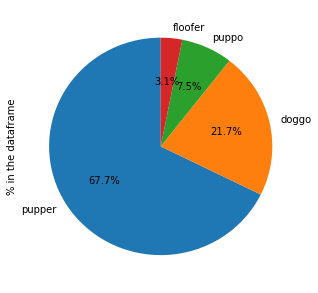

In [216]:
stages['% in the dataframe'].plot(kind='pie',labels=stages.stages, startangle=90, figsize=(5,5), autopct='%1.1f%%')

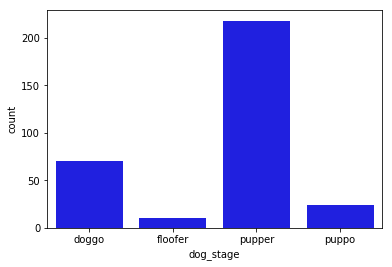

In [217]:
#Ploting the result
import seaborn as sb
sb.countplot(data=finalstages, x='dog_stage', color='blue')

Among all dog' stages, pupper is most common in Twitter, it appears 67.7% of the times, when not considering null/none dog stage's values

2. What are the top 10 tweeted breeds?

In [218]:
df_breed=final[['p1', 'p2', 'p3', 'p1_dog', 'p2_dog', 'p3_dog']]
#df_breed.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)
df_breed

,p1,p2,p3,p1_dog,p2_dog,p3_dog
0,Pomeranian,Pembroke,Chihuahua,True,True,True
1,Toy_Poodle,Miniature_Poodle,Teddy,True,True,False
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,Kuvasz,Golden_Retriever,Labrador_Retriever,True,True,True
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,Dalmatian,English_Setter,Great_Dane,True,True,True
8,Flat-Coated_Retriever,Chesapeake_Bay_Retriever,Curly-Coated_Retriever,True,True,True
9,Toyshop,Chihuahua,Brabancon_Griffon,False,True,True


In [219]:
p1_breeds=df_breed.p1.value_counts().head(10)
p1_breeds=pd.DataFrame(p1_breeds)
p1_breeds=p1_breeds.reset_index()
p1_breeds.rename(columns={'p1': 'sum'}, inplace=True)
p1_breeds

,index,sum
0,Golden_Retriever,132
1,Labrador_Retriever,91
2,Pembroke,84
3,Chihuahua,76
4,Pug,51
5,Samoyed,38
6,Chow,38
7,Pomeranian,36
8,Toy_Poodle,33
9,Malamute,28


In [220]:
p2_breeds=df_breed.p2.value_counts().head(10)
p3_breeds=df_breed.p3.value_counts().head(10)
p2_breeds=pd.DataFrame(p2_breeds)
p2_breeds=p2_breeds.reset_index()
p3_breeds=pd.DataFrame(p3_breeds)
p3_breeds=p3_breeds.reset_index()
p2_breeds.rename(columns={'p2': 'sum'}, inplace=True)
p3_breeds.rename(columns={'p3': 'sum'}, inplace=True)
p3_breeds

,index,sum
0,Labrador_Retriever,74
1,Chihuahua,56
2,Golden_Retriever,42
3,Eskimo_Dog,33
4,Kelpie,32
5,Staffordshire_Bullterrier,30
6,Chow,30
7,Kuvasz,30
8,Pekinese,28
9,Toy_Poodle,28


In [221]:
result=pd.concat([p1_breeds, p2_breeds, p3_breeds], axis=0, join='outer')
result=result.reset_index()
result=result[['index', 'sum']]
result=result.groupby(['index'])['sum'].sum()
result=pd.DataFrame(result)
result=result.reset_index()
result.columns=['breeds', 'total']
result.sort_values(by='total', axis=0, ascending=False, inplace=True)
result=result.head(10)
result

,breeds,total
10,Labrador_Retriever,257
7,Golden_Retriever,254
2,Chihuahua,172
19,Toy_Poodle,96
13,Pembroke,84
14,Pomeranian,72
0,Cardigan,70
3,Chow,68
15,Pug,51
6,French_Bulldog,38


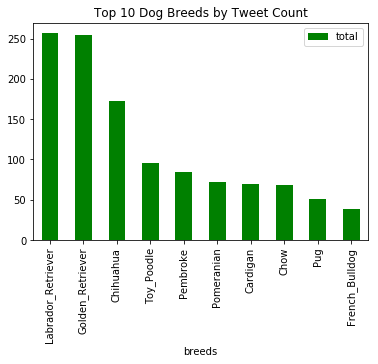

In [222]:
result.plot(kind='bar', x='breeds', y='total', color='green')
plt.title('Top 10 Dog Breeds by Tweet Count')
plt.show();

Labrador Retriever is the breed with more tweets, followed by Golden Retriever and Chihuahua. This result makes sense once they are really common breeds worldwide

3. Tweets Correlation: Favorites and Retweets

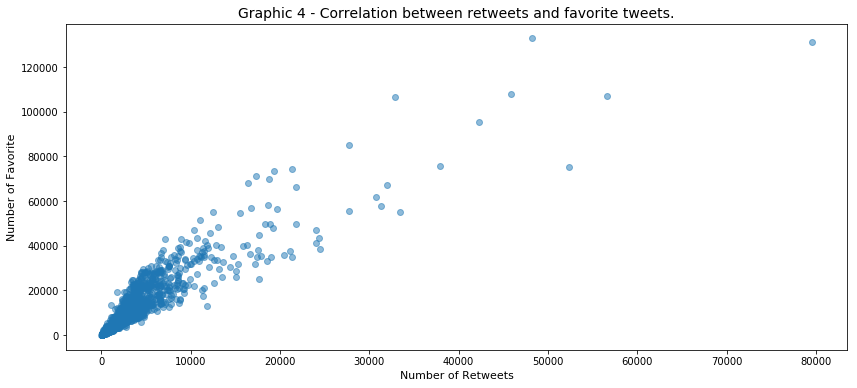

In [223]:
plt.figure(figsize= [14,6])                              
plt.scatter(x = final['retweet_count'],                  
            y = final['favorite_count'],                 
            alpha = transparency)                         
plt.xlabel('Number of Retweets', fontsize = font)         
plt.ylabel('Number of Favorite', fontsize = font)         
plt.title('Graphic 4 - Correlation between retweets and favorite tweets.',
          fontsize = font_title)    
plt.show()    

In [224]:
fav_ret_rate = final.favorite_count/final.retweet_count
fav_ret_rate.describe()

count    1990.000000
mean        3.354818
std         1.178232
min         1.097147
25%         2.529736
50%         3.175902
75%         3.931143
max        12.348718
dtype: float64

As we could imagine, there is a positive correlation between number of counted retweets and the number of counted favorites. As the number of retweets increase, the number of favorites increase too by 3 in average

4. What is the best day to post a Tweet? (Analysis by the size of the numerator, which will lead to better ratings / grades)

In [225]:
final.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'dog_stage', 'favorite_count', 'retweet_count'],
      dtype='object')

In [226]:
final.timestamp.dtype

dtype('<M8[ns]')

In [227]:
df_time = final.copy()

df_time = df_time[['timestamp','rating_numerator']]

# Converting date to weekdays. 1 = Monday, 2 = Tuesday, ... , 7 = Sunday
df_time.timestamp = list(map(lambda x : x.isoweekday(), df_time.timestamp))

df_time_mean = df_time.groupby(['timestamp']).mean()

df_time_mean.index = ['Monday','Tuesday','Wednesday','Thurday','Friday','Saturday','Sunday']

# Editing the variable name.
#df_time_mean.columns = ['Avg Rating','Tweets Number']

df_time_mean

,rating_numerator
Monday,10.554545
Tuesday,10.703993
Wednesday,10.525424
Thurday,10.785088
Friday,10.793556
Saturday,10.700772
Sunday,10.534884


In [228]:
df_time_mean=pd.DataFrame(df_time_mean)
df_time_mean=df_time_mean.reset_index()
df_time_mean.columns=['Weekdays', 'Avg. Rate']
df_time_mean

,Weekdays,Avg. Rate
0,Monday,10.554545
1,Tuesday,10.703993
2,Wednesday,10.525424
3,Thurday,10.785088
4,Friday,10.793556
5,Saturday,10.700772
6,Sunday,10.534884


In [229]:
# Number of tweets per week day
value_counts=df_time.timestamp.value_counts()
value_counts.index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
value_counts=pd.DataFrame(value_counts)
value_counts=value_counts.reset_index()
value_counts.columns=['Weekdays', 'Number of tweets']
value_counts

,Weekdays,Number of tweets
0,Monday,330
1,Tuesday,295
2,Wednesday,293
3,Thursday,285
4,Friday,270
5,Saturday,259
6,Sunday,258


In [230]:
df_time_mean = pd.merge(df_time_mean, value_counts, how='left', on=['Weekdays'])
df_time_mean

,Weekdays,Avg. Rate,Number of tweets
0,Monday,10.554545,330.0
1,Tuesday,10.703993,295.0
2,Wednesday,10.525424,293.0
3,Thurday,10.785088,NaN
4,Friday,10.793556,270.0
5,Saturday,10.700772,259.0
6,Sunday,10.534884,258.0


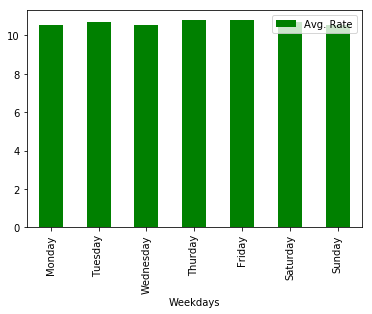

In [231]:
df_time_mean.plot.bar(x='Weekdays', y='Avg. Rate', color='green')

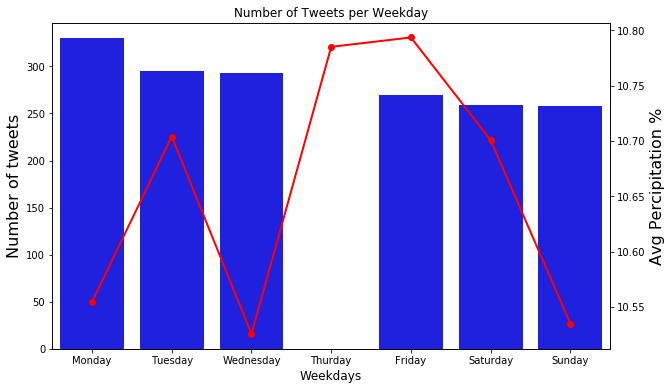

In [232]:
# 2 axis Graphic / Combo Chart
fig, ax1 = plt.subplots(figsize=(10,6))
#color = 'tab:green'
ax1.set_title('Number of Tweets per Weekday', fontsize=12)
ax1.set_xlabel('Days', fontsize=12)
ax1.set_ylabel('Number of Tweets', fontsize=16)
ax1 = sns.barplot(x='Weekdays', y='Number of tweets', data = df_time_mean, color='blue')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
#color = 'tab:red'
ax2.set_ylabel('Avg Percipitation %', fontsize=16)
ax2.plot(ax1.get_xticks(),
         df_time_mean[['Avg. Rate']].values,
         linestyle='-',
         marker='o', linewidth=2.0, color='red')
#ax2 = sns.lineplot(x='Weekdays', y='Avg. Rate', data = df_time_mean, sort=False, color=color)
#ax2.tick_params(axis='y', color=color)
plt.show()

5. What is the favorite dog breed? - Analysis based on the favorite_counts and retweets measures

In [233]:
final.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'dog_stage', 'favorite_count', 'retweet_count'],
      dtype='object')

In [234]:
fav=final[['p1','p2','p3', 'favorite_count', 'retweet_count']]
fav.sort_values(by=['favorite_count'], axis=0, ascending=False, inplace=True)
favorite=fav.head()

ret=fav.copy()
ret.sort_values(by=['retweet_count'], axis=0, ascending=False, inplace=True)
ret=ret.head()
ret

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,p1,p2,p3,favorite_count,retweet_count
1724,Labrador_Retriever,Ice_Bear,Whippet,131075,79515
1039,Chihuahua,Pomeranian,Toy_Terrier,107015,56625
1726,Eskimo_Dog,Siberian_Husky,Malamute,75163,52360
1971,Lakeland_Terrier,Labrador_Retriever,Irish_Terrier,132810,48265
173,English_Springer,Boston_Bull,Cardigan,107956,45849


In [235]:
final=pd.concat([favorite, ret], axis=0, join='outer')
final
#result=pd.concat([p1_breeds, p2_breeds, p3_breeds], axis=0, join='outer')

,p1,p2,p3,favorite_count,retweet_count
1971,Lakeland_Terrier,Labrador_Retriever,Irish_Terrier,132810,48265
1724,Labrador_Retriever,Ice_Bear,Whippet,131075,79515
173,English_Springer,Boston_Bull,Cardigan,107956,45849
1039,Chihuahua,Pomeranian,Toy_Terrier,107015,56625
1960,French_Bulldog,Boston_Bull,Pug,106827,32883
1724,Labrador_Retriever,Ice_Bear,Whippet,131075,79515
1039,Chihuahua,Pomeranian,Toy_Terrier,107015,56625
1726,Eskimo_Dog,Siberian_Husky,Malamute,75163,52360
1971,Lakeland_Terrier,Labrador_Retriever,Irish_Terrier,132810,48265
173,English_Springer,Boston_Bull,Cardigan,107956,45849


In [236]:
final=pd.melt(final, id_vars=['favorite_count', 'retweet_count'], value_vars=['p1','p2','p3'], var_name='probability', value_name='breed')
final.drop(columns=['probability'], inplace=True)
final

,favorite_count,retweet_count,breed
0,132810,48265,Lakeland_Terrier
1,131075,79515,Labrador_Retriever
2,107956,45849,English_Springer
3,107015,56625,Chihuahua
4,106827,32883,French_Bulldog
5,131075,79515,Labrador_Retriever
6,107015,56625,Chihuahua
7,75163,52360,Eskimo_Dog
8,132810,48265,Lakeland_Terrier
9,107956,45849,English_Springer


In [237]:
df_final = final.groupby(['breed'])['favorite_count','retweet_count'].sum()
df_final.sort_values(by='favorite_count', axis=0, ascending=False, inplace=True)
df_final.head()

,favorite_count,retweet_count
breed,,
Labrador_Retriever,527770,255560
Boston_Bull,322739,124581
Irish_Terrier,265620,96530
Lakeland_Terrier,265620,96530
Ice_Bear,262150,159030


In [238]:
df_final2= final.groupby(['breed'])['favorite_count','retweet_count'].sum()
df_final2.sort_values(by='retweet_count', axis=0, ascending=False, inplace=True)
df_final2=df_final2.head()
df_final2

,favorite_count,retweet_count
breed,,
Labrador_Retriever,527770,255560
Ice_Bear,262150,159030
Whippet,262150,159030
Boston_Bull,322739,124581
Chihuahua,214030,113250


Labrador Retriever seems to be the favorite breed. It is the one with the highest number on both favorite and retweets counts. 
Bonston Bull and Ice_Bear are also breeds present in both favorites' and retweets top 5 lists, therefore, can be considered as a popular / loved breeds too.

## CONCLUSION

The goal of this project is to wrangle and, after that, analyze and visualize the data from the Twitter Account "WeRateDogs".

The first step was to gather data from 3 different sources, which by its turn have different formats - Downloads through Excel, URL and gathering data from a Twitter API.

After that, 12 data quality issues and 3 tidness issues were identified (15 issues in total). 
The listed issues there then solved in the Cleaning session, where I performed also merges between the databases. The final output was stored as 'final.csv'.

In order to find some conclusions and trends on the data, I made some data analysis in the second part of this project. The results were also reinforced by plots. Thus, one could conclude that:

    - When excluding the dog stage "None / Null", pupper is most common dog stage in Twitter, it appears on 67.7% of the time.
    - Labrador Retriever is the breed with the highet number of counted tweets, followed by Golden Retriever and Chihuahua. In the top 10 tweeted breeds' list, we also have names such as (in descending order): Pembroke, Pomeranian, Cardigan, Toy Poodle, Chow, Pug, French Bulldog.
    - There is a positive correlation between the number of retweets and the number of favourites' tweets
    - Monday is the Weekday with the highest number of tweets. However, when looking to the ratings, their averages do not seem to vary a lot among the days. Therefore, although Friday is the day with the highest rating average, one can say that it does not make that much difference on when are you making a post, if your intention is to get a higher post rating.
    - By analyzing favorite_counts and retweets_counts measures,Labrador Retriever seems to be the favorite breed. Bonston Bull and Ice_Bear are also breeds present in both favorites' and retweets top 5 lists, therefore, they can be considered as a popular / loved breeds too. 